### **Step 0**: Import Library and Device Selection

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import json
import time
from datetime import datetime
from sklearn.manifold import TSNE
from torch.nn import functional as F
from sklearn.linear_model import LinearRegression

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---

### **Step 1**: Data Preprocessing

In [3]:
ensemble = np.load('ensemble_101.npz')

Facies = ensemble['Facies']     
Porosity = ensemble['Porosity']   

n_samples, n_channels, height, width = Porosity.shape
Porosity_flattened = Porosity.reshape(-1, height * width)
scaler = MinMaxScaler(feature_range=(0, 1))
Porosity_scaled = scaler.fit_transform(Porosity_flattened).reshape(n_samples, n_channels, height, width)
Porosity_scaled = np.clip(Porosity_scaled, 0, 1)

Properties = np.stack((Facies, Porosity_scaled), axis=1)

test_indies = [100]

test_properties = Properties[test_indies]

all_indices = np.arange(Properties.shape[0]) 
train_indices = np.setdiff1d(all_indices, test_indies)
train_properties = Properties[train_indices]

test_properties = torch.tensor(test_properties, dtype=torch.float32)
train_properties = torch.tensor(train_properties, dtype=torch.float32)


In [4]:
InSAR = np.load('InSAR.npy')

scaler = MinMaxScaler()
InSAR_reshaped = InSAR.reshape(-1, 1)
InSAR_scaled = scaler.fit_transform(InSAR_reshaped)
InSAR_scaled = InSAR_scaled.reshape(InSAR.shape)
InSAR_reshaped = InSAR_scaled.reshape(101, 1, 32, 32)

test_indices = [100]

InSAR_tensor = torch.tensor(InSAR_reshaped, dtype=torch.float32)
test_condition = InSAR_tensor[test_indices]
train_condition = InSAR_tensor[~np.isin(np.arange(InSAR_tensor.shape[0]), test_indices)]

InSAR_reshaped = InSAR_scaled.reshape(101, 1, 1, 32, 32)
InSAR_expanded = np.repeat(InSAR_reshaped, repeats=16, axis=2)
InSAR_tensor = torch.tensor(InSAR_expanded, dtype=torch.float32)
test_InSAR_without_noise = InSAR_tensor[test_indices]
train_InSAR_without_noise = InSAR_tensor[~np.isin(np.arange(InSAR_tensor.shape[0]), test_indices)]

random_noise = np.random.normal(0, 0.5, size=(101, 1, 16, 32, 32))
InSAR_with_noise = np.concatenate((InSAR_expanded, random_noise), axis=1)
InSAR_with_noise_tensor = torch.tensor(InSAR_with_noise, dtype=torch.float32)
test_InSAR_with_noise = InSAR_with_noise_tensor[test_indices]
train_InSAR_with_noise = InSAR_with_noise_tensor[~np.isin(np.arange(InSAR_with_noise_tensor.shape[0]), test_indices)]

combined_without_noise = torch.cat((train_InSAR_without_noise, test_InSAR_without_noise), dim=0)
combined_with_noise = torch.cat((train_InSAR_with_noise, test_InSAR_with_noise), dim=0)

InSAR = np.load('TVERDPLGEO.npy')

InSAR_Test_Image = InSAR[test_indices]
InSAR_Train_Image = np.delete(InSAR, test_indices, axis=0)

---

### **Step 2**: UNetGenerator and conditional Discriminator

In [5]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, features=[64, 128, 256, 512], dropout_prob=0.2):
        super(UNetGenerator, self).__init__()

        self.dropout_prob = dropout_prob

        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        self.bottleneck = self._block(features[-1], features[-1] * 2)

        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))

        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=self.dropout_prob)  # Dropout layer added here
        )

    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = nn.MaxPool3d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_conv(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=2, condition_channels=1, out_conv_channels=256, dropout_prob=0.3):
        super(Discriminator, self).__init__()
        
        total_in_channels = in_channels + condition_channels

        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        conv4_channels = out_conv_channels

        self.conv1 = nn.Sequential(
            nn.Conv3d(total_in_channels, conv1_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(conv1_channels, conv2_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(conv2_channels, conv3_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(conv3_channels, conv4_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(conv4_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)

        self.fc1 = nn.Linear(conv4_channels, 256)
        self.fc2 = nn.Linear(256, 1)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, condition):
        B, C, D, W, H = x.size()

        condition = condition.unsqueeze(2).repeat(1, 1, D, 1, 1)

        x_cond = torch.cat([x, condition], dim=1) 
        
        x = self.conv1(x_cond)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.global_avg_pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return torch.sigmoid(x)

---

### **Step 3**: Loss Functions and Logger for GAN Training

In [7]:
class GeneratorLoss(nn.Module):
    def __init__(self, alpha=100):
        super().__init__()
        self.alpha=alpha
        self.mse=nn.MSELoss()
        self.l1=nn.L1Loss()
        
    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        loss = self.mse(fake_pred, fake_target) + self.alpha* self.l1(fake, real)
        return loss
    
class DiscriminatorLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss_fn = nn.MSELoss()
        
    def forward(self, fake_pred, real_pred):
        fake_target = torch.zeros_like(fake_pred)
        real_target = torch.ones_like(real_pred)
        fake_loss = self.loss_fn(fake_pred, fake_target)
        real_loss = self.loss_fn(real_pred, real_target)
        loss = (fake_loss + real_loss)/2
        return loss

In [8]:
class Logger():
    def __init__(self, exp_name: str='./runs01', filename: str=None):
        self.exp_name = exp_name
        self.cache = {}
        if not os.path.exists(exp_name):
            os.makedirs(exp_name, exist_ok=True)
        self.date = datetime.today().strftime("%B_%d_%Y_%I_%M%p")
        if filename is None:
            self.filename = self.date
        else:
            self.filename = "_".join([self.date, filename])
        self.fpath = f"{self.exp_name}/{self.filename}.json"
        with open(self.fpath, 'w') as f:
            json.dump(self.cache, f)
    
    def add_scalar(self, key: str, value: float, t: int):
        if key not in self.cache:
            self.cache[key] = {}
        self.cache[key][t] = value  
        self.update()
    
    def save_weights(self, state_dict, model_name: str='model'):
        fpath = f"{self.exp_name}/{model_name}.pt"
        torch.save(state_dict, fpath)
    
    def update(self):
        with open(self.fpath, 'w') as f:
            json.dump(self.cache, f) 
    
    def close(self):
        self.update()
        self.cache = {}

---

### **Step 4**: Training Loop for GAN with UNet Generator and Discriminator

In [9]:
num_epochs = 10
batch_size = 50

generator = UNetGenerator(in_channels=2, out_channels=2).to(device)
discriminator = Discriminator(out_conv_channels=256).to(device)

dataset = TensorDataset(train_InSAR_with_noise, train_properties, train_condition)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterionG = GeneratorLoss(alpha=100).to(device)
criterionD = DiscriminatorLoss().to(device)

beta1 = 0.5  
optimizerG = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=1e-5, betas=(beta1, 0.999))

In [10]:
g_loss_history = []
d_loss_history = []

logger = Logger(filename='training_log')

start = time.time()

num_generator_updates = 2

for epoch in range(num_epochs):
    ge_loss = 0.0
    de_loss = 0.0

    for latent_variables, real_data, condition in data_loader:
        latent_variables = latent_variables.to(device)
        real_data = real_data.to(device)
        condition = condition.to(device)

        # === Discriminator Update ===
        optimizerD.zero_grad()
        fake_data = generator(latent_variables)

        fake_pred = discriminator(fake_data.detach(), condition)
        real_pred = discriminator(real_data, condition)

        lossD = criterionD(fake_pred, real_pred)
        lossD.backward()
        optimizerD.step()

        # === Generator Update ===
        for _ in range(num_generator_updates):
            optimizerG.zero_grad()

            fake_data = generator(latent_variables)
            fake_pred = discriminator(fake_data, condition).view(-1)

            lossG = criterionG(fake_data, real_data, fake_pred)
            lossG.backward()
            optimizerG.step()

        ge_loss += lossG.item()
        de_loss += lossD.item()

    g_loss = ge_loss / len(data_loader)
    d_loss = de_loss / len(data_loader)

    g_loss_history.append(g_loss)
    d_loss_history.append(d_loss)

    end = time.time()
    tm = (end - start)
    logger.add_scalar('generator_loss', g_loss, epoch+1)
    logger.add_scalar('discriminator_loss', d_loss, epoch+1)

    if epoch <= 500:
        if epoch % 5 == 0:
            logger.save_weights(generator.state_dict(), f'generator_{str(epoch).zfill(4)}')
            logger.save_weights(discriminator.state_dict(), f'discriminator_{str(epoch).zfill(4)}')
    else:
        if epoch % 100 == 0:
            logger.save_weights(generator.state_dict(), f'generator_{str(epoch).zfill(4)}')
            logger.save_weights(discriminator.state_dict(), f'discriminator_{str(epoch).zfill(4)}')
    
    print("[Epoch %d/%d] [G loss: %.4f] [D loss: %.4f] ETA: %.3fs" % (epoch+1, num_epochs, g_loss, d_loss, tm))

    fake_data = generator(latent_variables).detach().cpu()
    facies_output = fake_data[:, 0, :, :, :]
    porosity_output = fake_data[:, 1, :, :, :]

    facies_output = (facies_output > 0.5).float()

logger.close()

[Epoch 1/10] [G loss: 65.2555] [D loss: 0.2493] ETA: 1.516s
[Epoch 2/10] [G loss: 56.6746] [D loss: 0.2500] ETA: 2.880s
[Epoch 3/10] [G loss: 43.8465] [D loss: 0.2515] ETA: 3.725s
[Epoch 4/10] [G loss: 36.0768] [D loss: 0.2478] ETA: 4.534s
[Epoch 5/10] [G loss: 33.9164] [D loss: 0.2480] ETA: 5.335s
[Epoch 6/10] [G loss: 32.3573] [D loss: 0.2471] ETA: 6.126s
[Epoch 7/10] [G loss: 31.3881] [D loss: 0.2433] ETA: 7.509s
[Epoch 8/10] [G loss: 31.5716] [D loss: 0.2410] ETA: 8.310s
[Epoch 9/10] [G loss: 30.3529] [D loss: 0.2393] ETA: 9.126s
[Epoch 10/10] [G loss: 29.5998] [D loss: 0.2408] ETA: 9.925s


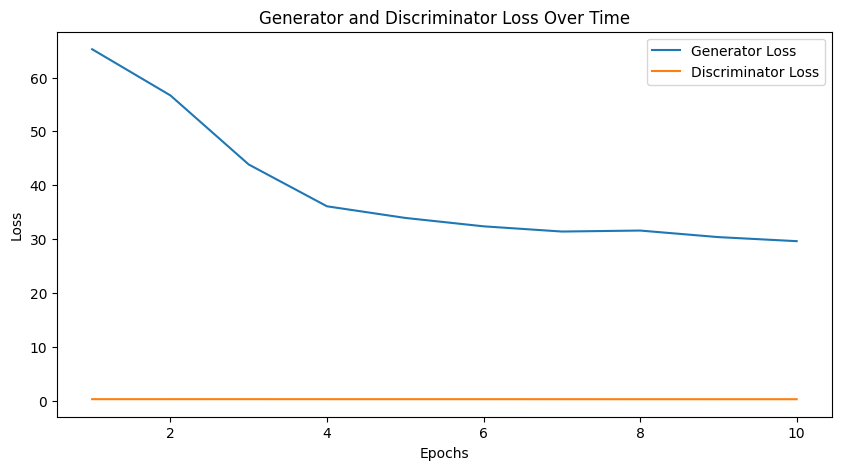

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), g_loss_history, label='Generator Loss')
plt.plot(range(1, num_epochs + 1), d_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Time')
plt.legend()
plt.show()

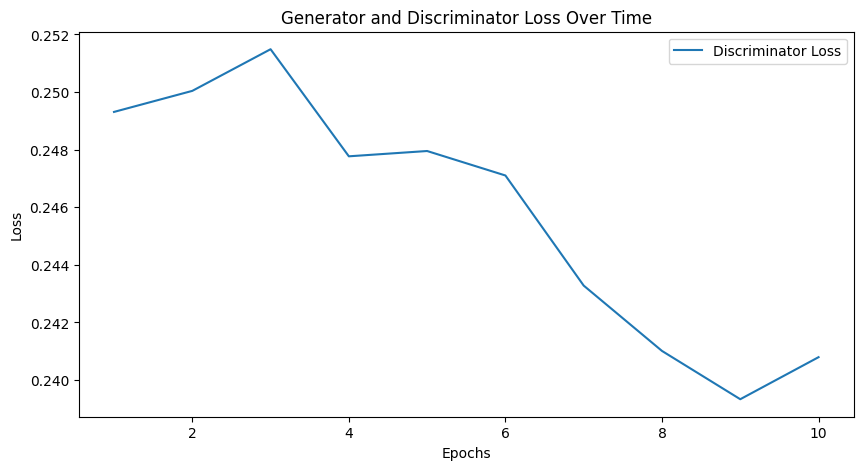

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), d_loss_history, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Time')
plt.legend()
plt.show()

---

### **Step 5**: Batch Processing and Saving of GAN Generated Outputs with Memory Management

In [13]:
generator = UNetGenerator(in_channels=2, out_channels=2).to(device)
generator.load_state_dict(torch.load('generator_0925.pt'))

C:\Users\Dell\AppData\Local\Temp\ipykernel_22376\3888794375.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_0925.pt'))


<All keys matched successfully>

In [14]:
batch_size = 100
num_batches = len(combined_with_noise) // batch_size

output_dir = 'output_batches01'
os.makedirs(output_dir, exist_ok=True)

generator = generator.to(device)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size

    batch_data = combined_with_noise[start_idx:end_idx].to(device)

    with torch.no_grad(): 
          output = generator(batch_data)

    output_file = os.path.join(output_dir, f'batch_{i:04d}.pt')
    torch.save(output.cpu(), output_file)

    del batch_data
    del output
    torch.cuda.empty_cache()

    print(f"Batch {i + 1}/{num_batches} processed and saved to {output_file}")

if len(combined_with_noise) % batch_size != 0:
    start_idx = num_batches * batch_size
    remaining_data = combined_with_noise[start_idx:].to(device)

    with torch.no_grad():
        output = generator(remaining_data)

    output_file = os.path.join(output_dir, f'batch_{num_batches:04d}.pt')
    torch.save(output.cpu(), output_file)

    del remaining_data
    del output
    torch.cuda.empty_cache()

    print(f"Remaining data processed and saved to {output_file}")


output_dir = 'output_batches01'
batch_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.pt')])

results = []
for batch_file in batch_files:
    batch_result = torch.load(batch_file)
    results.append(batch_result)

final_result = torch.cat(results, dim=0)

Batch 1/1 processed and saved to output_batches01\batch_0000.pt
Remaining data processed and saved to output_batches01\batch_0001.pt


C:\Users\Dell\AppData\Local\Temp\ipykernel_22376\1823638643.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_result = torch.load(batch_file)


In [15]:
facies_output = final_result[:, 0, :, :, :]
porosity_output = final_result[:, 1, :, :, :]

facies_output = (facies_output > 0.4).float()

---

### **Step 6**: Visualization of Input, Target, and Prediction

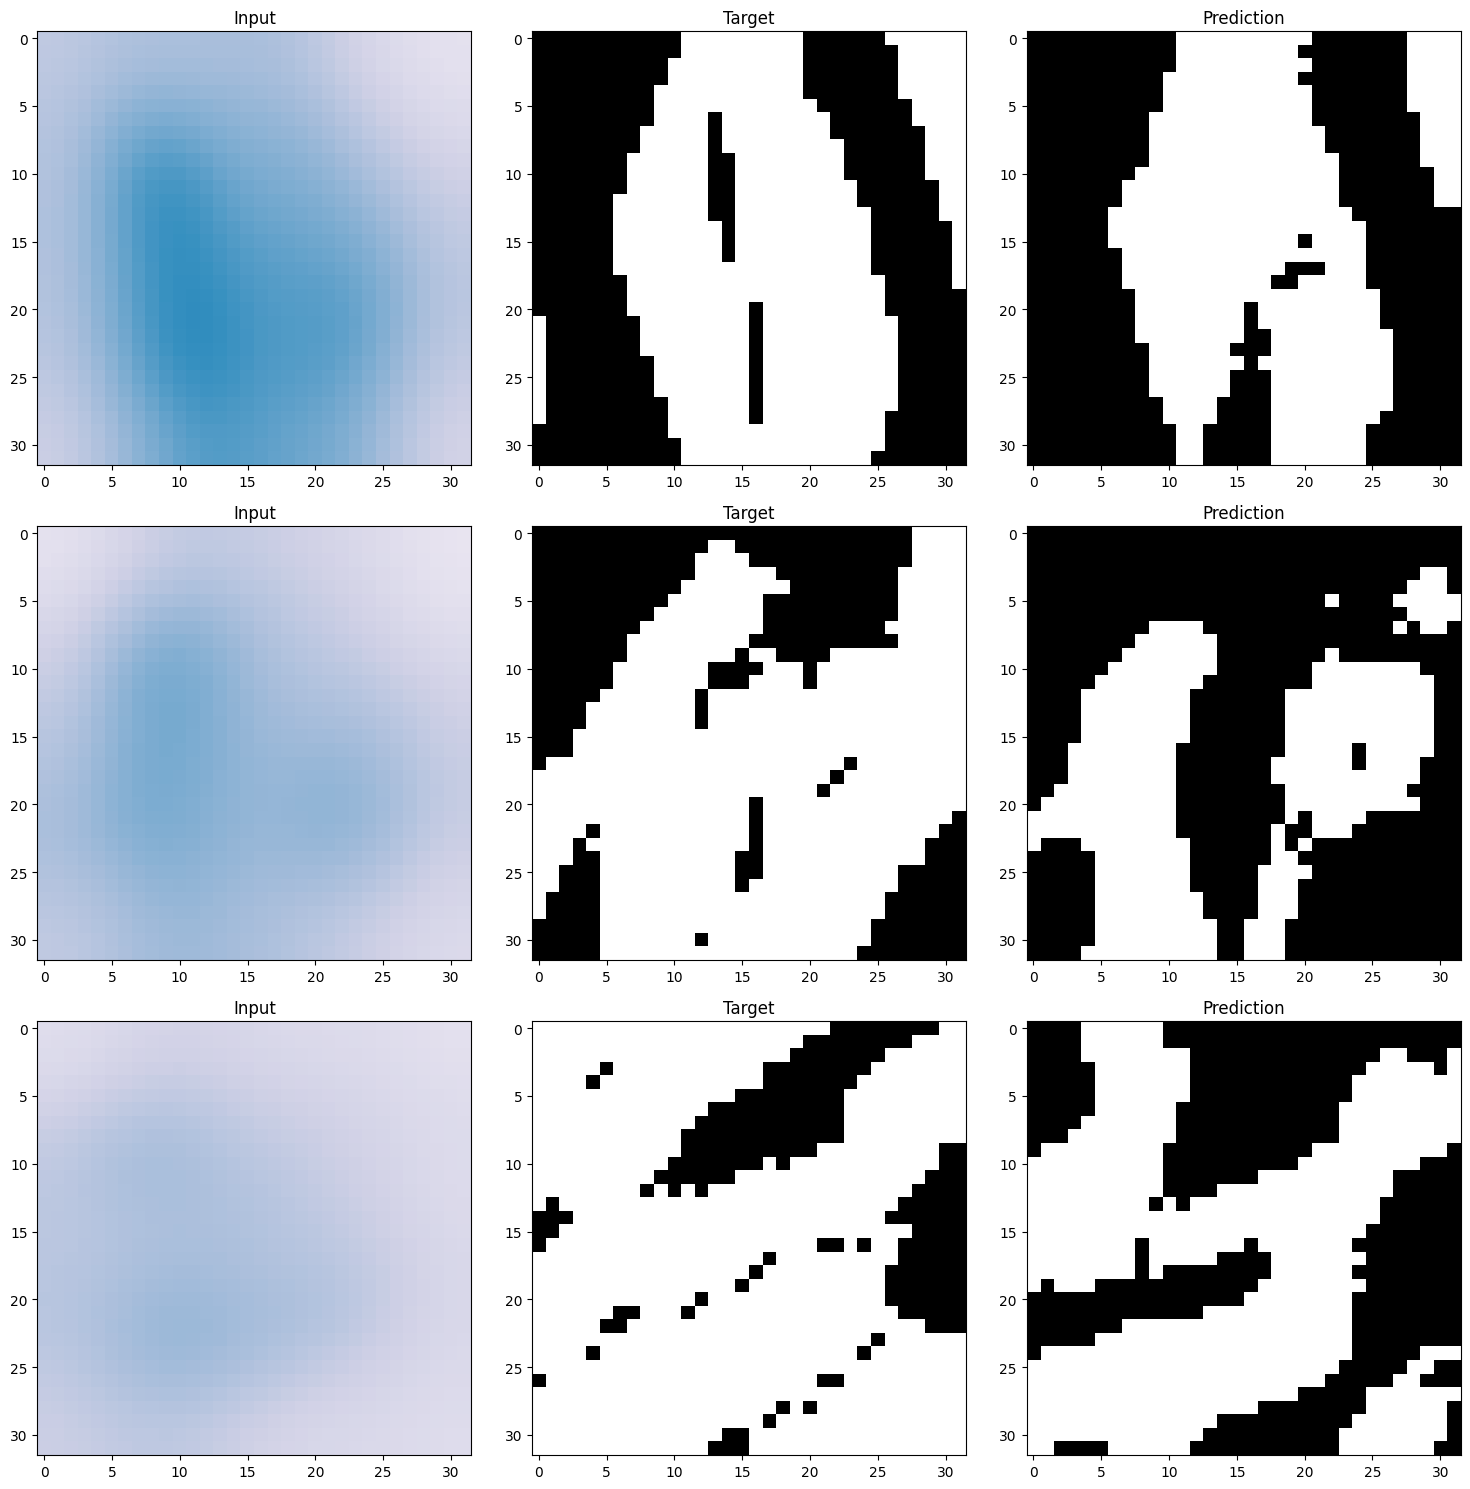

In [16]:
plt.figure(figsize=(15, 15))

for i in range(3):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(np.array(InSAR_Train_Image)[i*30, :, :], cmap='PuBu', vmin = 0, vmax = 0.155)
    plt.title('Input')

    plt.subplot(3, 3, 3*i+2)
    plt.imshow(np.array(train_properties.detach().cpu()[i*30][0, 0, :, :]), cmap='gray', vmin=0, vmax=1)
    plt.title('Target')

    plt.subplot(3, 3, 3*i+3)
    plt.imshow(np.array(facies_output.detach().cpu()[i*30][0, :, :]), cmap='gray', vmin=0, vmax=1)
    plt.title('Prediction')

plt.tight_layout()

plt.show()

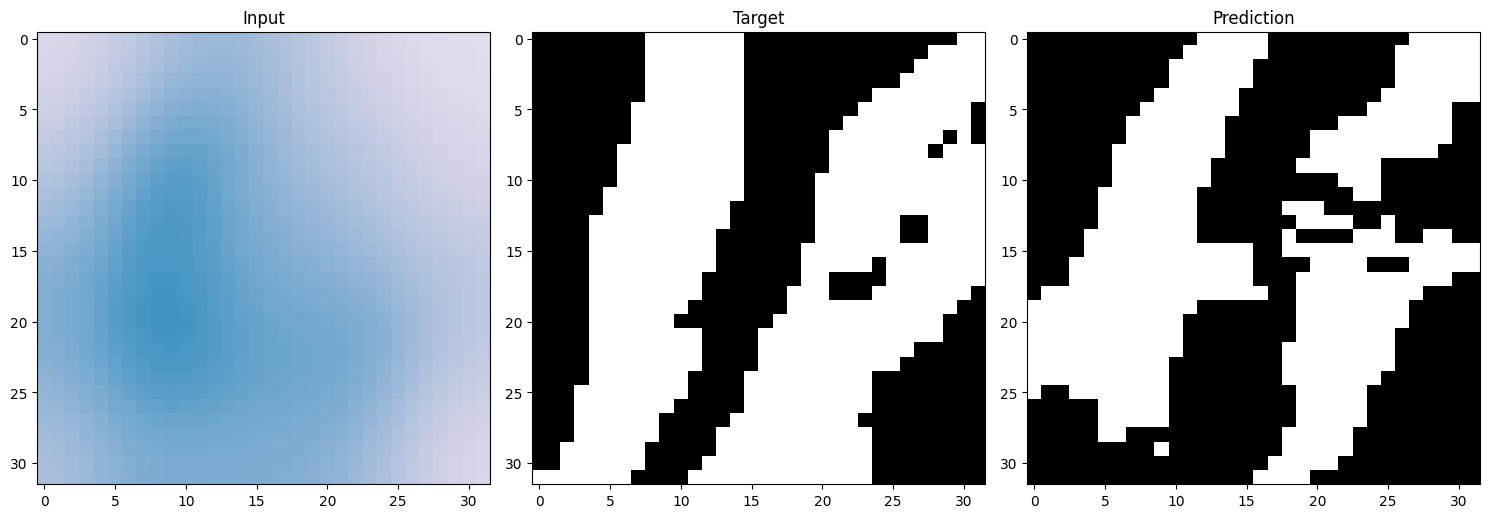

In [17]:

plt.figure(figsize=(15, 5))

for i in range(1):
    plt.subplot(1, 3, 3*i+1)
    plt.imshow(np.array(InSAR_Test_Image)[i, :, :], cmap='PuBu', vmin = 0, vmax = 0.155)
    plt.title('Input')

    plt.subplot(1, 3, 3*i+2)
    plt.imshow(np.array(test_properties.detach().cpu()[i][0, 0, :, :]), cmap='gray', vmin=0, vmax=1)
    plt.title('Target')

    plt.subplot(1, 3, 3*i+3)
    plt.imshow(np.array(facies_output.detach().cpu()[100+i][0, :, :]), cmap='gray', vmin=0, vmax=1)
    plt.title('Prediction')

plt.tight_layout()

plt.show()

---

### **Step 7**: Visualization of Realizations from InSAR Data with Dropout and Random Noise

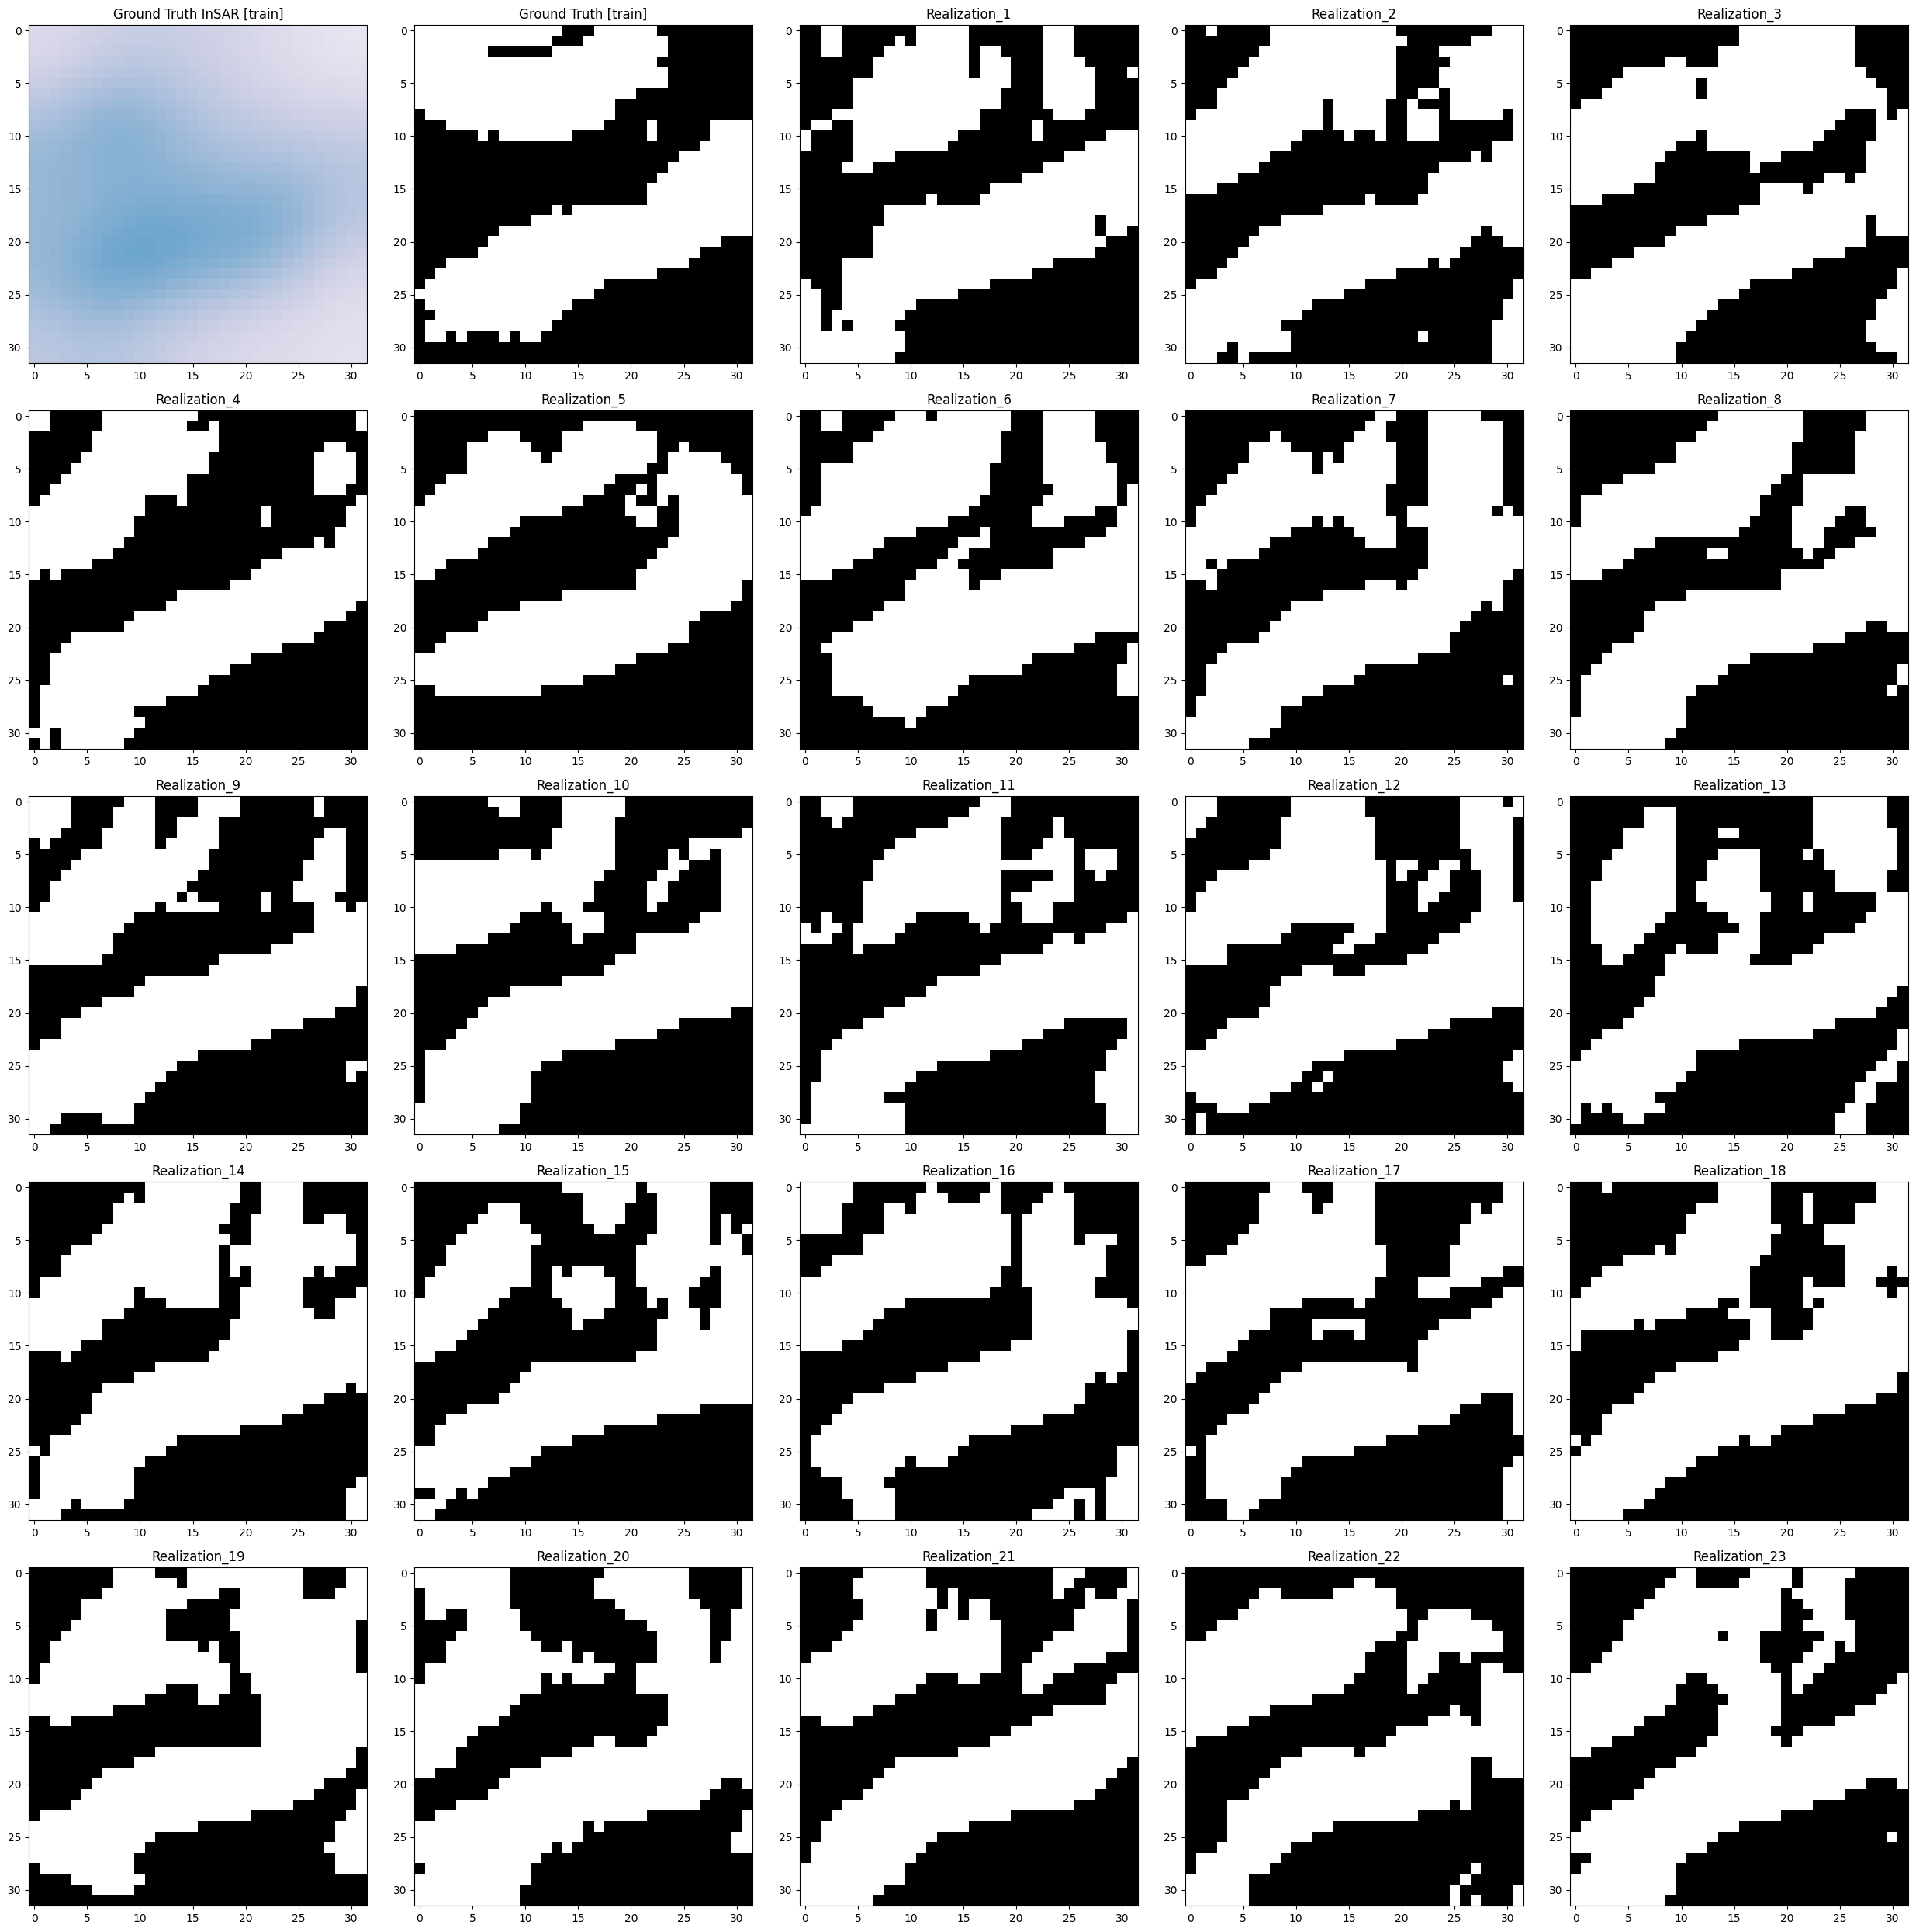

In [18]:
num = 25
plt.figure(figsize=(25, 25))

generator.train()

for i in range(num):
    if i == 0:
        plt.subplot(5, 5, 1)
        plt.imshow(np.array(InSAR_Train_Image)[70, :, :], cmap='PuBu', vmin = 0, vmax = 0.155)
        plt.title('Ground Truth InSAR [train]')
    elif i == 1:
        plt.subplot(5, 5, 2)
        plt.imshow(np.array(train_properties.detach().cpu()[70, 0, 0, :, :]), cmap='gray', vmin=0, vmax=1)
        plt.title('Ground Truth [train]')
    else:
        random_noise = torch.randn((1, 1, 16, 32, 32)) * 0.01
        train_with_noise = torch.cat((train_InSAR_without_noise[70].reshape(1, 1, 16, 32, 32), random_noise), dim=1)
        train_out = generator(train_with_noise.to(device))
        
        # Facies output
        facies_train_output = train_out[:, 0, :, :, :]

        sand_ratio = (facies_train_output > 0.5).float().mean().item() + 0.1

        facies_train_output = (facies_train_output > sand_ratio).float()

        plt.subplot(5, 5, i + 1)
        plt.imshow(np.array(facies_train_output.detach().cpu()[0, 0, :, :]), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Realization_{i - 1}')

plt.tight_layout()

plt.show()


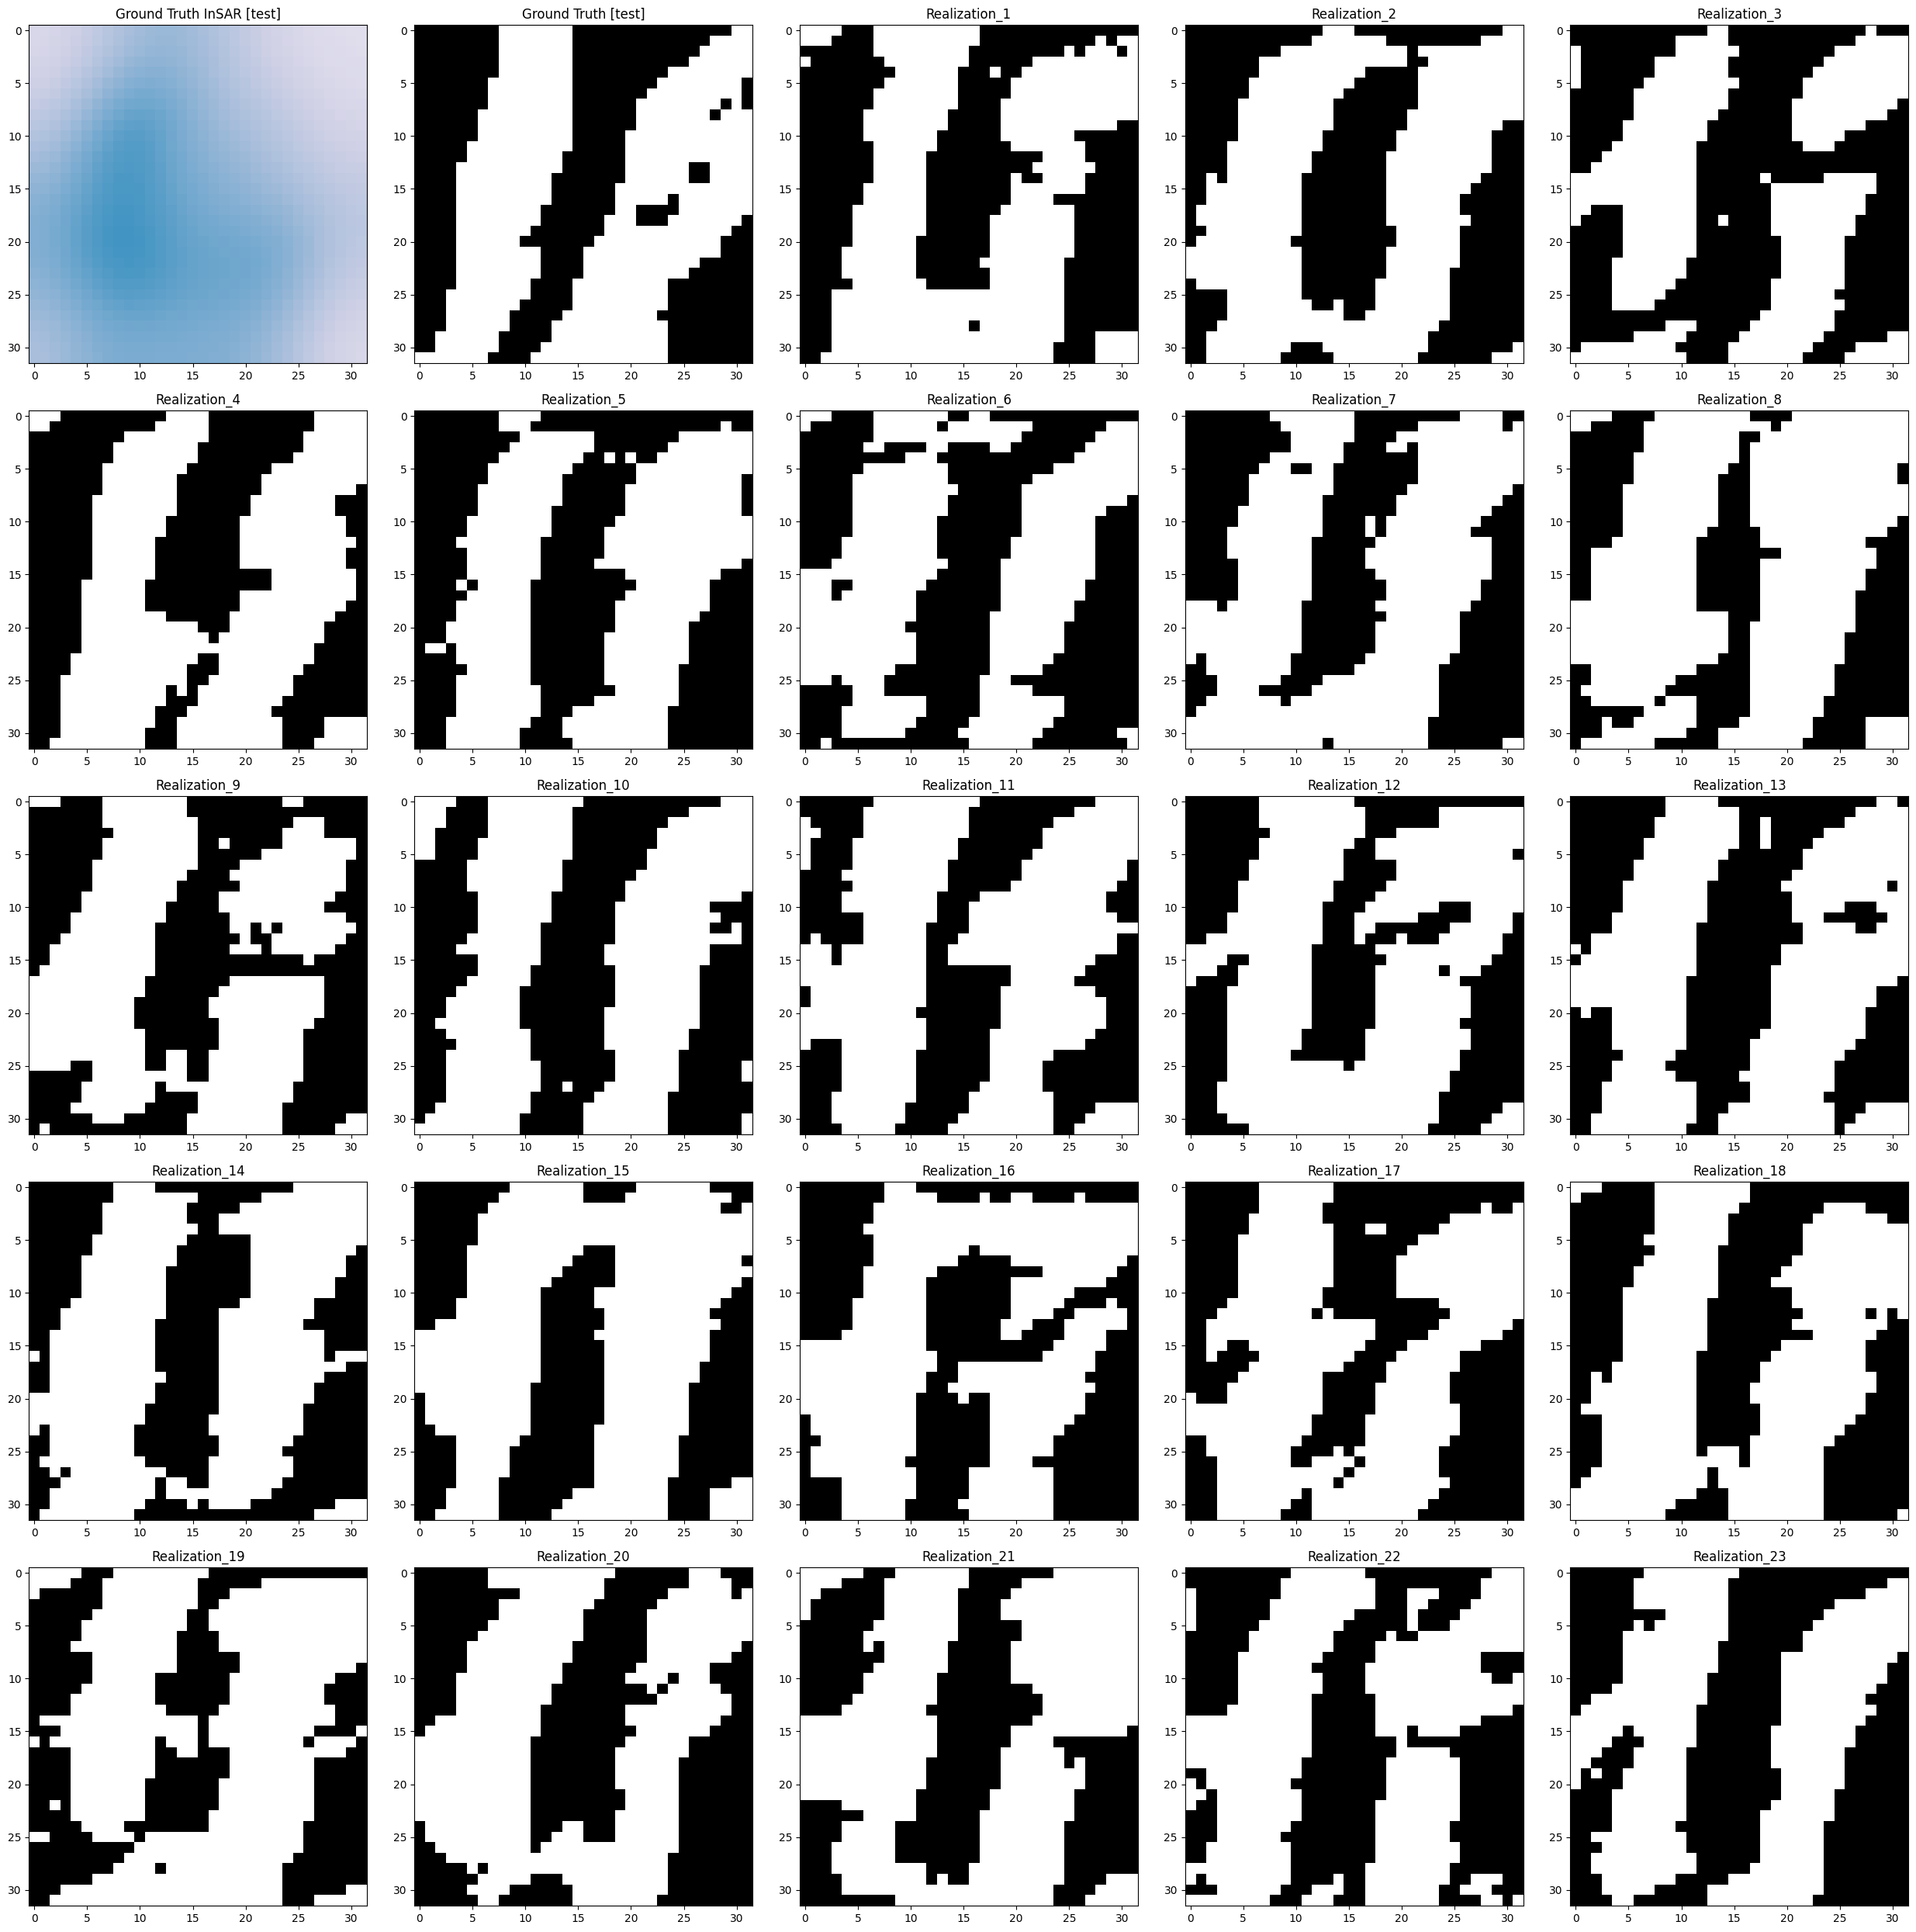

In [19]:
num = 25
plt.figure(figsize=(25, 25))

generator.train()

for i in range(num):
    if i == 0:
        plt.subplot(5, 5, 1)
        plt.imshow(np.array(InSAR_Test_Image)[0, :, :], cmap='PuBu', vmin = 0, vmax = 0.155)
        plt.title('Ground Truth InSAR [test]')
    elif i == 1:
        plt.subplot(5, 5, 2)
        plt.imshow(np.array(test_properties.detach().cpu()[0, 0, 0, :, :]), cmap='gray', vmin=0, vmax=1)
        plt.title('Ground Truth [test]')
    else:
        random_noise = torch.randn((1, 1, 16, 32, 32)) * 0.01
        test_with_noise = torch.cat((test_InSAR_without_noise[0].reshape(1, 1, 16, 32, 32), random_noise), dim=1)
        test_out = generator(test_with_noise.to(device))
        
        facies_test_output = test_out[:, 0, :, :, :]

        sand_ratio = (facies_test_output > 0.5).float().mean().item() + 0.04

        facies_test_output = (facies_test_output > sand_ratio).float()

        plt.subplot(5, 5, i + 1)
        plt.imshow(np.array(facies_test_output.detach().cpu()[0, 0, :, :]), cmap='gray', vmin=0, vmax=1)
        plt.title(f'Realization_{i - 1}')

plt.tight_layout()

plt.show()


---

### **Step 8**: Post-Processing

In [20]:
Facies = ensemble['Facies']
Porosity = ensemble['Porosity']
Permeability = ensemble['Permeability']

n_samples, n_channels, height, width = Porosity.shape
Porosity_flattened = Porosity.reshape(-1, height * width)
scaler = MinMaxScaler(feature_range=(0, 1))
Porosity_scaled = scaler.fit_transform(Porosity_flattened).reshape(n_samples, n_channels, height, width)

combined_properties_real = torch.cat((train_properties, test_properties), dim=0)
porosity_real = combined_properties_real[:,1,:]  

porosity_real_flat = porosity_real.detach().cpu().numpy().reshape(-1, height * width) 
porosity_real_scaled = scaler.inverse_transform(porosity_real_flat)
porosity_real_scaled = porosity_real_scaled.reshape(n_samples, n_channels, height, width)

porosity_output_flat = porosity_output.detach().cpu().numpy().reshape(-1, height * width)   
porosity_output_scaled = scaler.inverse_transform(porosity_output_flat) 
porosity_output_scaled = porosity_output_scaled.reshape(101, n_channels, height, width)

In [21]:
def calculate_cdf(data, num_bins=20000):
    data_flat = data.flatten()
    hist, bin_edges = np.histogram(data_flat, bins=num_bins, density=True)
    cdf = np.cumsum(hist) * np.diff(bin_edges)
    normalized_cdf = cdf / cdf[-1]
    return bin_edges[1:], normalized_cdf

def match_cdf(prediction, target_cdf, target_bins):
    prediction_flat = prediction.flatten()
    matched_prediction = np.interp(prediction_flat, target_bins, target_cdf)
    return matched_prediction.reshape(prediction.shape)

def rescale_to_original_range(data, original_min, original_max):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min) * (original_max - original_min) + original_min

bin_edges_real, cdf_real = calculate_cdf(porosity_real_scaled)

original_min = porosity_real_scaled[100].min()
original_max = porosity_real_scaled[100].max()

target_porosity = porosity_real_scaled[100]  
bin_edges_target, cdf_target = calculate_cdf(target_porosity)  

porosity_test_ensemble = []
porosity_output_flat = porosity_output.reshape(-1, height * width)
porosity_output_rescaled = scaler.inverse_transform(porosity_output_flat)
porosity_output_rescaled = porosity_output_rescaled.reshape(101, 16, 32, 32)

output_gaussian_noise_before_cdf = np.random.normal(0, 0.005, porosity_output_rescaled.shape)  # 표준편차 0.005
porosity_output_rescaled += output_gaussian_noise_before_cdf

porosity_test_output_mapped = match_cdf(porosity_output_rescaled, cdf_target, bin_edges_target)

output_gaussian_noise_after_rescale = np.random.normal(0, 0.005, porosity_test_output_mapped.shape)  # 표준편차 0.005
porosity_test_output_mapped += output_gaussian_noise_after_rescale

porosity_test_output_mapped_rescaled = rescale_to_original_range(
    porosity_test_output_mapped, original_min, original_max
)

porosity_test_ensemble.append(porosity_test_output_mapped_rescaled)
porosity_test_ensemble = np.array(porosity_test_ensemble)

In [22]:
Facies = ensemble['Facies']         
Porosity = ensemble['Porosity']       
Permeability = ensemble['Permeability'] 

n_samples = Porosity.shape[0] * Porosity.shape[1] * Porosity.shape[2] * Porosity.shape[3]

Porosity_flat = Porosity.reshape(n_samples)
Permeability_flat = Permeability.reshape(n_samples)
Facies_flat = Facies.reshape(n_samples)

mask_sand = (Facies_flat == 1)
mask_shale = (Facies_flat == 0)

X_sand = Porosity_flat[mask_sand].reshape(-1, 1)
y_sand = Permeability_flat[mask_sand]

X_shale = Porosity_flat[mask_shale].reshape(-1, 1)
y_shale = Permeability_flat[mask_shale]

X_sand_log = np.log(X_sand + 1e-9)
y_sand_log = np.log(y_sand + 1e-9)

X_shale_log = np.log(X_shale + 1e-9)
y_shale_log = np.log(y_shale + 1e-9)

model_sand = LinearRegression()
model_sand.fit(X_sand_log, y_sand_log)

r2_score_sand = model_sand.score(X_sand_log, y_sand_log)

model_shale = LinearRegression()
model_shale.fit(X_shale_log, y_shale_log)

r2_score_shale = model_shale.score(X_shale_log, y_shale_log)

print(f'R² Score (Multiple Regression - Sand): {r2_score_sand}')
print(f'R² Score (Multiple Regression - Shale): {r2_score_shale}')

R² Score (Multiple Regression - Sand): 1.0
R² Score (Multiple Regression - Shale): 1.0


In [23]:
from tqdm import tqdm 

facies_output = facies_output.reshape(101, 16, 32, 32)
porosity_test_ensemble = porosity_test_ensemble[0]
porosity_log = np.log(porosity_test_ensemble + 1e-9)

permeability_pred = np.zeros_like(facies_output, dtype=np.float64)

for i in tqdm(range(facies_output.shape[0]), desc='Processing Facies'):
    for j in range(facies_output.shape[1]):
        for k in range(facies_output.shape[2]):
            for l in range(facies_output.shape[3]):
                if facies_output[i, j, k, l] == 1:  # sand
                    permeability_pred[i, j, k, l] = model_sand.predict([[porosity_log[i, j, k, l]]])[0]
                elif facies_output[i, j, k, l] == 0:  # shale
                    permeability_pred[i, j, k, l] = model_shale.predict([[porosity_log[i, j, k, l]]])[0]

permeability_pred.shape

Processing Facies: 100%|██████████| 101/101 [03:48<00:00,  2.26s/it]


(101, 16, 32, 32)

In [24]:
permeability_pred_original_scale = np.exp(permeability_pred) - 1e-9 

In [25]:
facies_output1 = facies_output.detach().cpu().numpy()

ensemble_output_101 = {                                  
    'Facies': facies_output1,    
    'Porosity': porosity_test_ensemble,            
    'Permeability': permeability_pred_original_scale  
}

np.savez('gen_ensemble_101.npz', Facies=facies_output1, Porosity=porosity_test_ensemble, Permeability=permeability_pred_original_scale)

---

### **Step 9**: 2D Visualization

In [26]:
ensemble = np.load('ensemble_101.npz')
gen = np.load('gen_ensemble_101.npz')
InSAR = np.load('TVERDPLGEO.npy')

Facies_initial = ensemble['Facies']
Porosity_initial = ensemble['Porosity']
Permeability_initial = ensemble['Permeability']

Facies_gen = gen['Facies']
Porosity_gen = gen['Porosity']
Permeability_gen = gen['Permeability']

In [27]:
def plot_data(index, InSAR, Facies, Porosity, Permeability, title_prefix):
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1,4, 1)
    plt.imshow(InSAR[index, :, :], cmap='PuBu')
    plt.title(f'InSAR')
    
    plt.subplot(1,4, 2)
    plt.imshow(Facies[index, 0, :, :], cmap='gray')
    plt.title(f'{title_prefix} Facies')
    
    plt.subplot(1,4, 3)
    plt.imshow(Porosity[index, 0, :, :], cmap='viridis')
    plt.title(f'{title_prefix} Porosity')
    
    plt.subplot(1,4, 4)
    plt.imshow(Permeability[index, 0, :, :], cmap='plasma')
    plt.title(f'{title_prefix} Permeability')
    
    plt.tight_layout()
    plt.show()

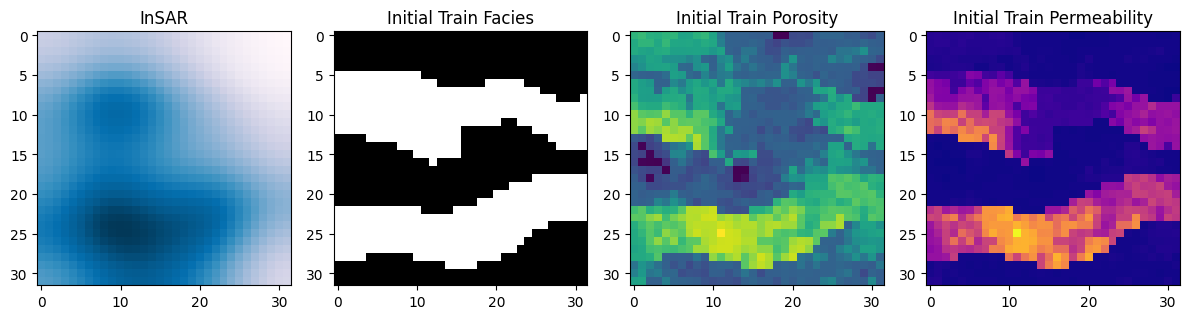

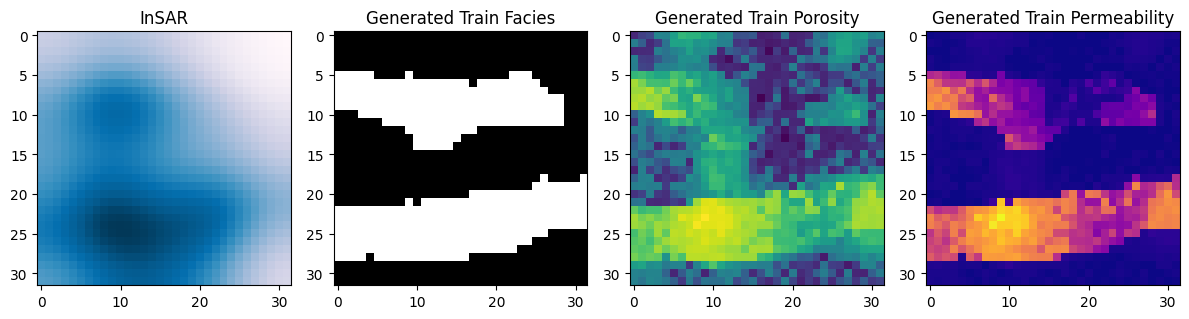

In [28]:
train_indices = [90]
for idx in train_indices:
    plot_data(idx, InSAR, Facies_initial, Porosity_initial, Permeability_initial, title_prefix='Initial Train')

for idx in train_indices:
    plot_data(idx, InSAR, Facies_gen, Porosity_gen, Permeability_gen, title_prefix='Generated Train')

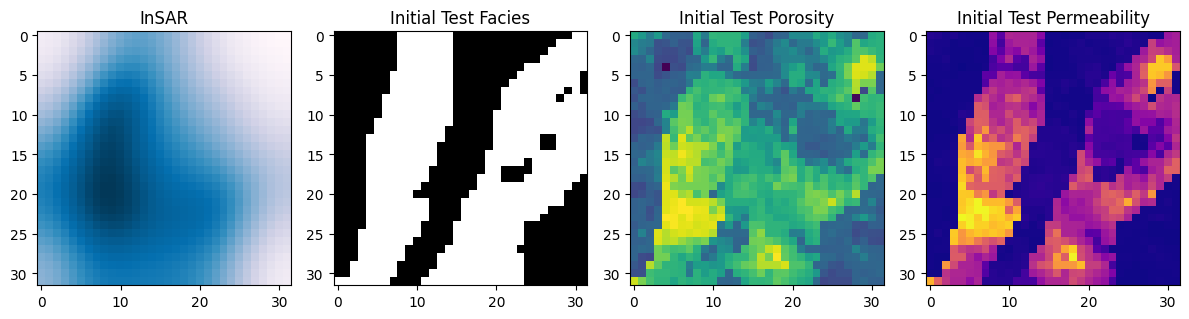

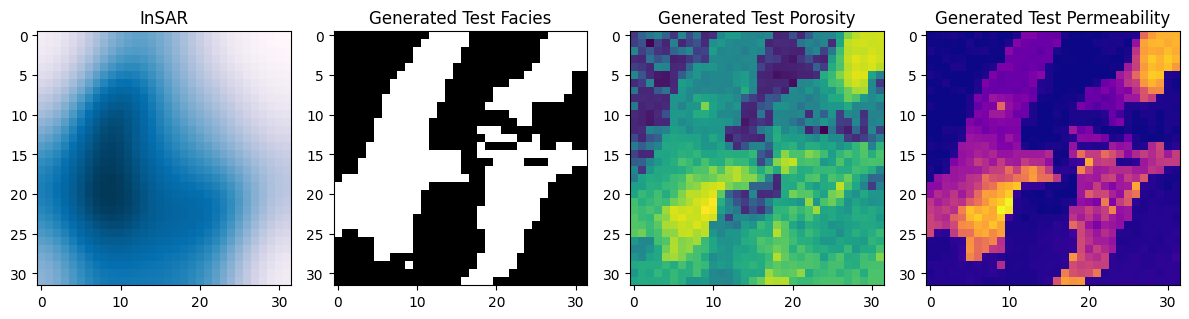

In [29]:
test_indices = [100]

for idx in test_indices:
    plot_data(idx, InSAR, Facies_initial, Porosity_initial, Permeability_initial, title_prefix='Initial Test')

# Plot generated test
for idx in test_indices:
    plot_data(idx, InSAR, Facies_gen, Porosity_gen, Permeability_gen, title_prefix='Generated Test')

---